In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

MEASUREMENTS_PER_SAMPLE = 100
CSV_FILE_PATH = '../gyroscope_data_updated.csv'

In [3]:
SAMPLE_STEP = 5

df = pd.read_csv(CSV_FILE_PATH)

targets_and_samples = []

def prepareForOneLabel(label, df):
    l_df = df[df['activity_type'] == label]
    l_df = l_df[l_df.columns[0:-1]]
    samples_number = (l_df.shape[0] - MEASUREMENTS_PER_SAMPLE) // SAMPLE_STEP
    
    def getSample(sample_index):
        sample_start_index = sample_index * SAMPLE_STEP
        sample_end_index = (sample_index * SAMPLE_STEP) + MEASUREMENTS_PER_SAMPLE
        
        return l_df[sample_start_index:sample_end_index].values.reshape(1, MEASUREMENTS_PER_SAMPLE, 6)
    
    return [[label, getSample(sample_index)] for sample_index in range(samples_number)]

for label in df['activity_type'].unique():
    targets_and_samples.extend(prepareForOneLabel(label, df))

samples = np.concatenate([ts[1] for ts in targets_and_samples])
targets = LabelBinarizer().fit_transform(np.array([ts[0] for ts in targets_and_samples]))

print(samples.shape)
print(targets.shape)

(15220, 100, 6)
(15220, 5)


In [4]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [5]:
train_part_in_percents = 0.6
val_part_in_percents = 0.2
test_part_in_percents = 0.2

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(9132, 100, 6)
(9132, 5)
(3044, 100, 6)
(3044, 5)
(3044, 100, 6)
(3044, 5)


In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(test_labels.shape[-1], activation='softmax'))

In [7]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.0005),
              loss='mse',
              metrics=['accuracy'])

In [8]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_acc', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

%time history = model.fit(train_data, train_labels, epochs=100, callbacks=callbacks, batch_size=64, validation_data=(val_data, val_labels))

Train on 9132 samples, validate on 3044 samples
Epoch 1/100
9132/9132 [==============================] - 1s 137us/step - loss: 0.2172 - acc: 0.4260 - val_loss: 0.1906 - val_acc: 0.5007
Epoch 2/100
9132/9132 [==============================] - 1s 104us/step - loss: 0.1592 - acc: 0.5543 - val_loss: 0.1100 - val_acc: 0.6771
Epoch 3/100
9132/9132 [==============================] - 1s 102us/step - loss: 0.1163 - acc: 0.6582 - val_loss: 0.0796 - val_acc: 0.7576
Epoch 4/100
9132/9132 [==============================] - 1s 106us/step - loss: 0.0954 - acc: 0.7159 - val_loss: 0.0726 - val_acc: 0.7898
Epoch 5/100
9132/9132 [==============================] - 1s 103us/step - loss: 0.0797 - acc: 0.7570 - val_loss: 0.0574 - val_acc: 0.8288
Epoch 6/100
9132/9132 [==============================] - 1s 104us/step - loss: 0.0673 - acc: 0.7948 - val_loss: 0.0466 - val_acc: 0.8650
Epoch 7/100
9132/9132 [==============================] - 1s 101us/step - loss: 0.0571 - acc: 0.8233 - val_loss: 0.0397 - val_acc: 

9132/9132 [==============================] - 1s 126us/step - loss: 0.0050 - acc: 0.9852 - val_loss: 0.0022 - val_acc: 0.9931
Epoch 61/100
9132/9132 [==============================] - 1s 124us/step - loss: 0.0052 - acc: 0.9834 - val_loss: 0.0021 - val_acc: 0.9934
Epoch 62/100
9132/9132 [==============================] - 1s 122us/step - loss: 0.0050 - acc: 0.9851 - val_loss: 0.0038 - val_acc: 0.9885
Epoch 63/100
9132/9132 [==============================] - 1s 123us/step - loss: 0.0047 - acc: 0.9863 - val_loss: 0.0021 - val_acc: 0.9928
Epoch 64/100
9132/9132 [==============================] - 1s 129us/step - loss: 0.0045 - acc: 0.9867 - val_loss: 0.0017 - val_acc: 0.9941
Epoch 65/100
9132/9132 [==============================] - 1s 121us/step - loss: 0.0042 - acc: 0.9866 - val_loss: 0.0017 - val_acc: 0.9954
Epoch 66/100
9132/9132 [==============================] - 1s 121us/step - loss: 0.0045 - acc: 0.9865 - val_loss: 0.0015 - val_acc: 0.9967
Epoch 67/100
9132/9132 [=======================

              acc     val_acc        loss    val_loss
count  100.000000  100.000000  100.000000  100.000000
mean     0.949847    0.966577    0.016967    0.011455
std      0.087833    0.069363    0.031365    0.024947
min      0.425975    0.500657    0.002731    0.001071
25%      0.958114    0.974786    0.003755    0.001830
50%      0.981001    0.990473    0.006358    0.003323
75%      0.988420    0.994744    0.013859    0.008163
max      0.991897    0.997372    0.217236    0.190627


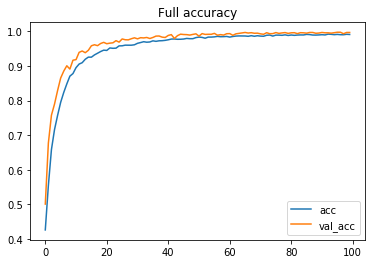

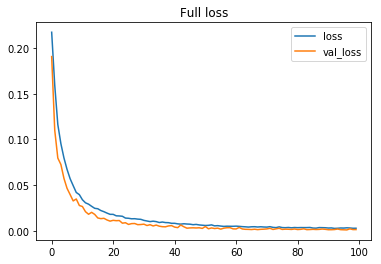

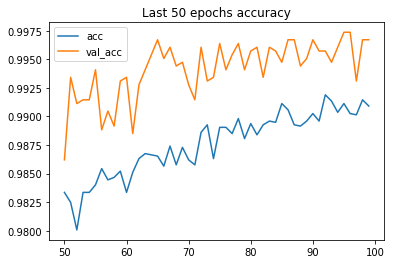

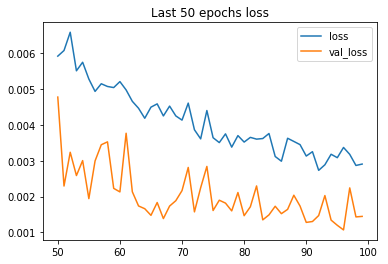

In [9]:
%matplotlib inline

history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [10]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [11]:
best_model.evaluate(test_data, test_labels)

3044/3044 [==============================] - 0s 59us/step


[0.0013638972864221798, 0.9960578186596584]

In [12]:
best_model.predict(test_data[0:1])

array([[1.16111376e-04, 1.36501301e-04, 5.21120955e-06, 9.99013543e-01,
        7.28616375e-04]], dtype=float32)